# 统计 new structural entropy
## & new distance structural entropy

## 统计  Wikipedia

In [57]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np
from dotenv import dotenv_values
import collections
import pandas as pd
from matplotlib.ticker import FuncFormatter

env_config = dotenv_values("../.env")

In [58]:
import pandas as pd
# 打开一个 xlsx 文件
XLSX_WRITER = pd.ExcelWriter('new_structural_entropy.xlsx', engine="xlsxwriter")

def draw_xlsx_sheet(sheet_writer, df, sheetTitle, chartTitle,x_axis_label,
                    y_axis_label, x_axis_options={}, y_axis_options={}, graph_size_df=None):
    
    if graph_size_df is not None:
        graph_size_df = graph_size_df.add_suffix('_size')
        df_excel = df.merge(graph_size_df, left_index=True, right_index=True)
        df_excel.to_excel(sheet_writer, sheet_name=sheetTitle, index=True)
    else:
        df.to_excel(sheet_writer, sheet_name=sheetTitle, index=True)

    workbook = sheet_writer.book
    worksheet = sheet_writer.sheets[sheetTitle]

    # 获取数据范围
    num_rows, num_cols = df.shape  # 获取行数和列数
    start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
    end_row = start_row + num_rows - 1  # 数据结束行
    category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
    sales_col = 1  # 销售列（第 2 列）

    # 创建折线图
    chart = workbook.add_chart({"type": "line"})
    for col_idx, col_name in enumerate(df.columns, start=1):
        chart.add_series({
            "name":       col_name,  # 图表中的系列名称
            "categories": [sheetTitle, start_row, category_col, end_row, category_col],  # 分类轴为索引
            "values":     [sheetTitle, start_row, col_idx, end_row, col_idx],  # 值列
        })
        
    chart.set_title({"name": chartTitle})
    x_axis_options['name'] = x_axis_label
    y_axis_options['name'] = y_axis_label
    chart.set_x_axis(x_axis_options)
    chart.set_y_axis(y_axis_options)
    chart.set_size({'width': 600, 'height': 400})
    
    chart.set_legend({'position': 'right',
                      'max_width': 500,
                      'overlay': False,
                      'font': {'size': 9, 'bold': False}
                      })

    # 插入图表
    worksheet.insert_chart("F2", chart)

In [59]:
database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
wikipedia_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_structural_entropy"]
wikipedia_entropy_collection.count_documents({})

66

In [60]:
start_year, end_year = 2004,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)


entropy_lv = {
    "degree entropy":np.full(end_year-start_year+1,np.nan),
    'structural entropy':np.full(end_year-start_year+1,np.nan),
    # 'delta':np.full(end_year-start_year+1,np.nan)
}
for lv in range(3,4):
    for doc in wikipedia_entropy_collection.find({'level':lv}):
        index = doc['year'] - start_year
        if index <= 0:
            continue
        entropy_lv['structural entropy'][index] = doc['entropy']['littlestructuralentropy']    
        entropy_lv['degree entropy'][index] = doc['entropy']['bigdegreeentropy']    
        
entropy_lv['KQI'] = entropy_lv['degree entropy'] - entropy_lv['structural entropy']
df = pd.DataFrame(entropy_lv, index=year_range)

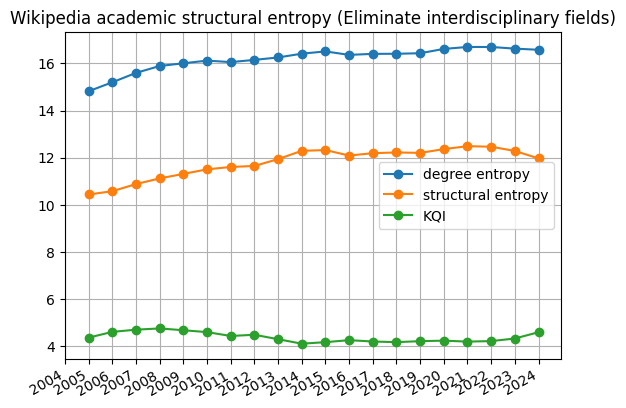

In [61]:
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("Wikipedia academic structural entropy (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [62]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "Wikipedia",
                "Wikipedia academic In-Degree KQI",
                "Year",
                "Entropy", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1},
                )

In [63]:
# df.plot( marker='o')
# # plt.xlim(start_year, end_year)
# plt.title("wikipedia academic structural entropy (Eliminate interdisciplinary fields)")
# plt.xticks(year_range)
# plt.grid()
# plt.gcf().autofmt_xdate()

# openalex

In [64]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_structural_entropy"]
openalex_entropy_collection.count_documents({})

517

In [65]:
start_year, end_year = 1940,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

entropy_data_list = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
   
for doc in openalex_entropy_collection.find({ 'rankType':'current', 
                                             'startPercent':0, }):
    if isinstance(doc['entropy'],float):
        continue
    
    index = doc['year'] - start_year
    if index < 0:
        continue
    endPercent = doc['endPercent']
    if endPercent not in [10,40, 60,100]:
        continue
    
    key = f"top {endPercent}% degree entropy"
    entropy_data_list[key][index] = doc['entropy']['bigdegreeentropy']
    key = f"top {endPercent}% structural entropy"
    entropy_data_list[key][index] = doc['entropy']['littlestructuralentropy']
    key = f"top {endPercent}% KQI"
    entropy_data_list[key][index] = doc['entropy']['bigdegreeentropy']- doc['entropy']['littlestructuralentropy']

len(entropy_data_list)

12

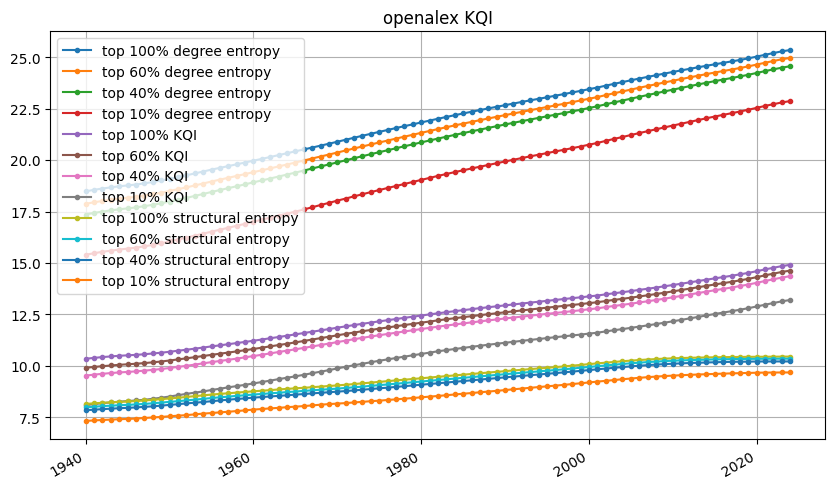

In [66]:
df = pd.DataFrame(entropy_data_list, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]

# plt.figure(figsize=(22, 10))  # 宽度为 10 英寸，高度为 6 英寸
df.plot(marker=".",figsize=(10, 6))
# plt.xlim(start_year, end_year)
plt.title("openalex KQI")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()

In [67]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OpenAlex",
                "OpenAlex In-Degree KQI",
                "Year",
                "Entropy", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1},
                )

# OpenAlex sub displine

In [68]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_structural_entropy_subdispline"]
openalex_entropy_collection.count_documents({})

2559

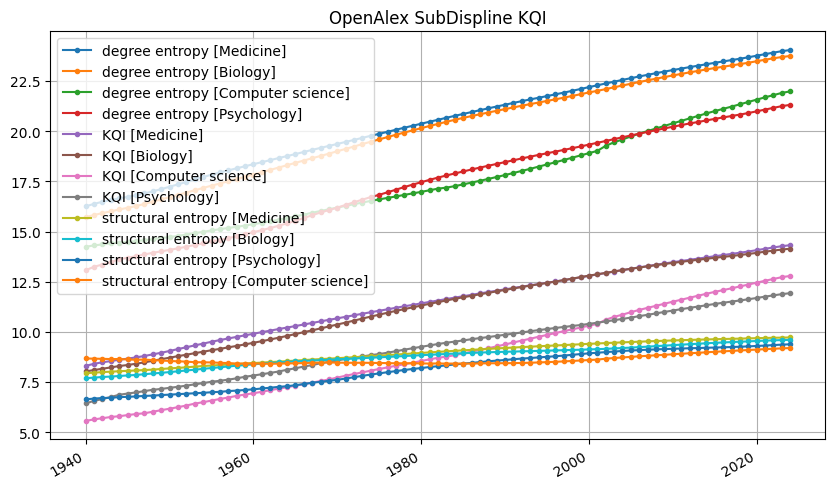

In [69]:
displine_list = ["Medicine", "Biology", "Computer science", "Psychology"]

start_year, end_year = 1940,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

entropy_data_dict = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
   
for doc in openalex_entropy_collection.find({ 'rankType':'current', 
                                             'endPercent':100, }):
    if isinstance(doc['entropy'],float):
        continue
    
    index = doc['year'] - start_year
    if index < 0:
        continue
    # endPercent = doc['endPercent']
    # if endPercent not in [10,40, 60,100]:
    #     continue
    
    displine = doc['subject']
    
    key = f"degree entropy [{displine}]"
    entropy_data_dict[key][index] = doc['entropy']['bigdegreeentropy']
    key = f"structural entropy [{displine}]"
    entropy_data_dict[key][index] = doc['entropy']['littlestructuralentropy']
    key = f"KQI [{displine}]"
    entropy_data_dict[key][index] = doc['entropy']['bigdegreeentropy']- doc['entropy']['littlestructuralentropy']


df = pd.DataFrame(entropy_data_dict, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]

# plt.figure(figsize=(22, 10))  # 宽度为 10 英寸，高度为 6 英寸
df.plot(marker=".",figsize=(10, 6))
# plt.xlim(start_year, end_year)
plt.title("OpenAlex SubDispline KQI")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()

In [70]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OpenAlex SubDispline",
                "OpenAlex In-Degree SubDispline KQI",
                "Year",
                "Entropy", y_axis_options = {'num_format': '#,##0','min':5, 'minor_unit':1},
                )

# distance entropy complexy

## wikipedia
用 点距离替代学科边计算的 distance complexity

In [71]:
database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
wikipedia_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_distance_compllexity"]
wikipedia_entropy_collection.count_documents({})

66

In [72]:
start_year, end_year = 2004,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)


entropy_lv = {
    "degree complexity":np.full(end_year-start_year+1,np.nan),
    'structural complexity':np.full(end_year-start_year+1,np.nan),
    # 'delta':np.full(end_year-start_year+1,np.nan)
}
lv = 3
for doc in wikipedia_entropy_collection.find({'level':lv}):
    index = doc['year'] - start_year
    if index <= 0:
        continue
    entropy_lv['structural complexity'][index] = doc['complexity']['littlcomplexity']    
    entropy_lv['degree complexity'][index] = doc['complexity']['bigcomplexity']    
        
entropy_lv['KQI'] = entropy_lv['degree complexity'] - entropy_lv['structural complexity']
df = pd.DataFrame(entropy_lv, index=year_range)

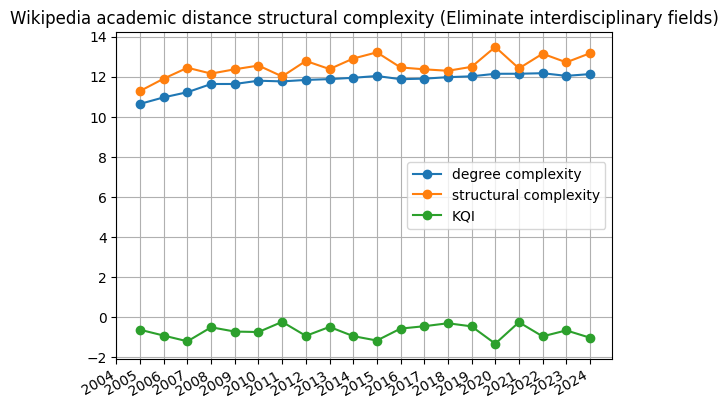

In [73]:
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("Wikipedia academic distance structural complexity (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [74]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "Wikipedia dsc",
                "Wikipedia academic distance structural complexity (Eliminate interdisciplinary fields)",
                "Year",
                "Entropy", y_axis_options = {'num_format': '#,##0','min':-4, 'minor_unit':1},
                )

In [75]:
XLSX_WRITER.close()